In [2]:
pip install -q nilearn neuroquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.8 MB/s eta 0:00:00


# ASD fMRI Exploration continued

In [3]:
import matplotlib.pyplot as plt
import nilearn
import nibabel
import numpy as np
import pandas as pd
import warnings

from tqdm.notebook import tqdm
from IPython.display import display, HTML
from neuroquery import fetch_neuroquery_model, NeuroQueryModel
from nilearn.plotting import view_img
from dataclasses import dataclass

warnings.filterwarnings('ignore') # nilearn is adding lots of non-breaking warnings

neuroquery_data = fetch_neuroquery_model()
encoder = NeuroQueryModel.from_data_dir(neuroquery_data)

Downloaded.


## Queries

In [4]:
@dataclass
class Query:
    text: str
    x: int
    y: int
    z: int

    @property
    def cut(self):
        return (self.x, self.y, self.z)

queries = [
    Query("consciousness", -4, -58, 24),
    Query("concentration", -22, -22, -14),
    Query("language comprehension", -50, 20, 10),
    Query("self-recognition", -38, -62, -16),
    Query("writing-comprehension", -58, -38, -2),
    Query("emotion", 22, -4, -18),
    Query("self-awareness", 36, 2, 2),
    Query("verbal comprehension", -58, -32, -2),
    Query("facial recognition", 36, -60, -20),
    Query("visual perception", -2, -82, 0),
    Query("semantic processing", -48, 10, 12),
    Query("memory acquisition", 0, -22, 0),
    Query("complex thought", -56, -26, 4),
    Query("procedural memory", 10, -56, -34),
    Query("sensory memory", -2, -82, 0),
    Query("short-term memory", 32, -56, 42),
    Query("theory of mind", -4, -62, 44),
]

In [5]:
for query in queries:
    for group in ["with", "without"]:
        full_query = f"{query.text} {group} autism spectrum disorder"
        result = encoder(full_query)
        view = view_img(result["brain_map"], threshold=3, cut_coords=query.cut)
        display(HTML(f"<h3>{full_query}</h3>"))
        display(view)

Output hidden; open in https://colab.research.google.com to view.

## Finding the slice with the greatest sum of differences

In [6]:
from nilearn import datasets

dataset_ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
dataset_ju = datasets.fetch_atlas_juelich('maxprob-thr0-1mm')

atlas_ho_filename = dataset_ho.filename
atlas_ju_filename = dataset_ju.filename

print('Atlas ROIs are located at: %s' % atlas_ho_filename)
print('Atlas ROIs are located at: %s' % atlas_ju_filename)


Dataset created in /root/nilearn_data/fsl



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/c4d84bbdf5c3325f23e304cdea1e9706/HarvardOxford.tgz..... done.


 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/ab1b53038e13028e55f691a69003c208/Juelich.tgz..... done.


Atlas ROIs are located at: /root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Atlas ROIs are located at: /root/nilearn_data/fsl/data/atlases/Juelich/Juelich-maxprob-thr0-1mm.nii.gz


-42.0 -69.0 52.0



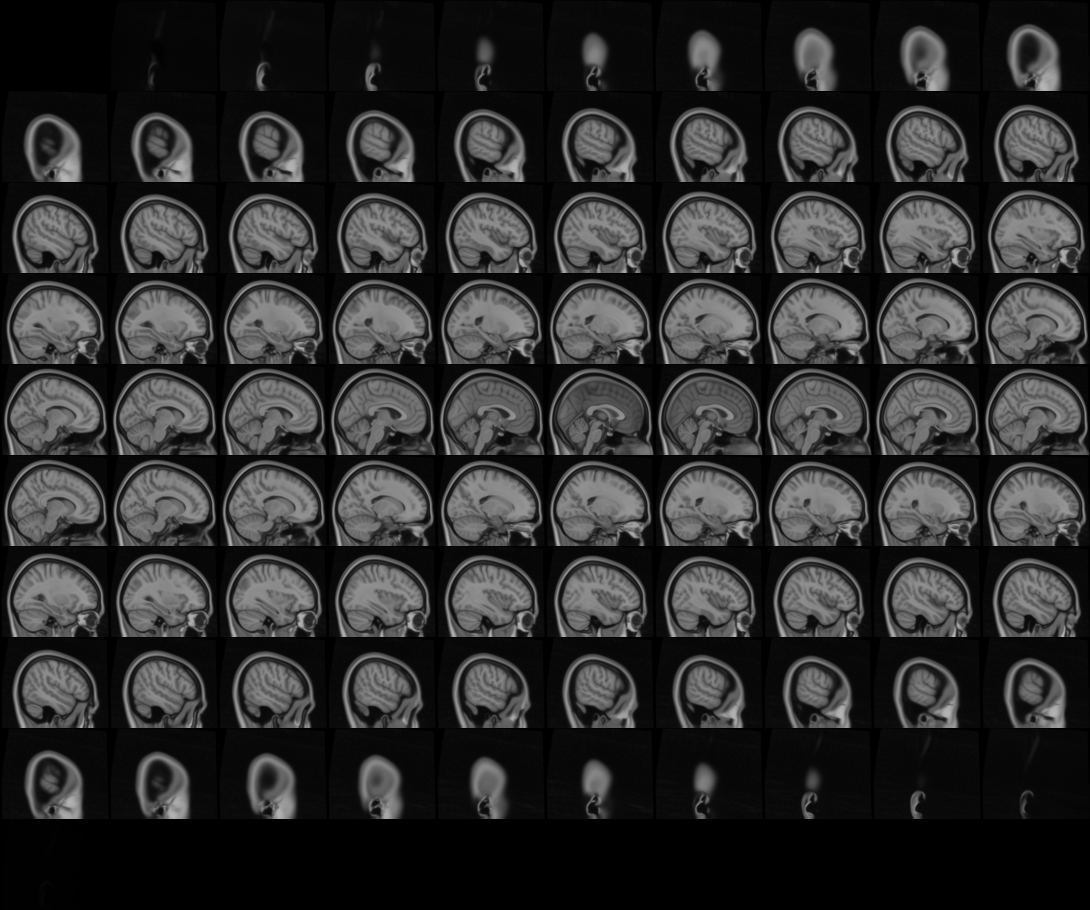
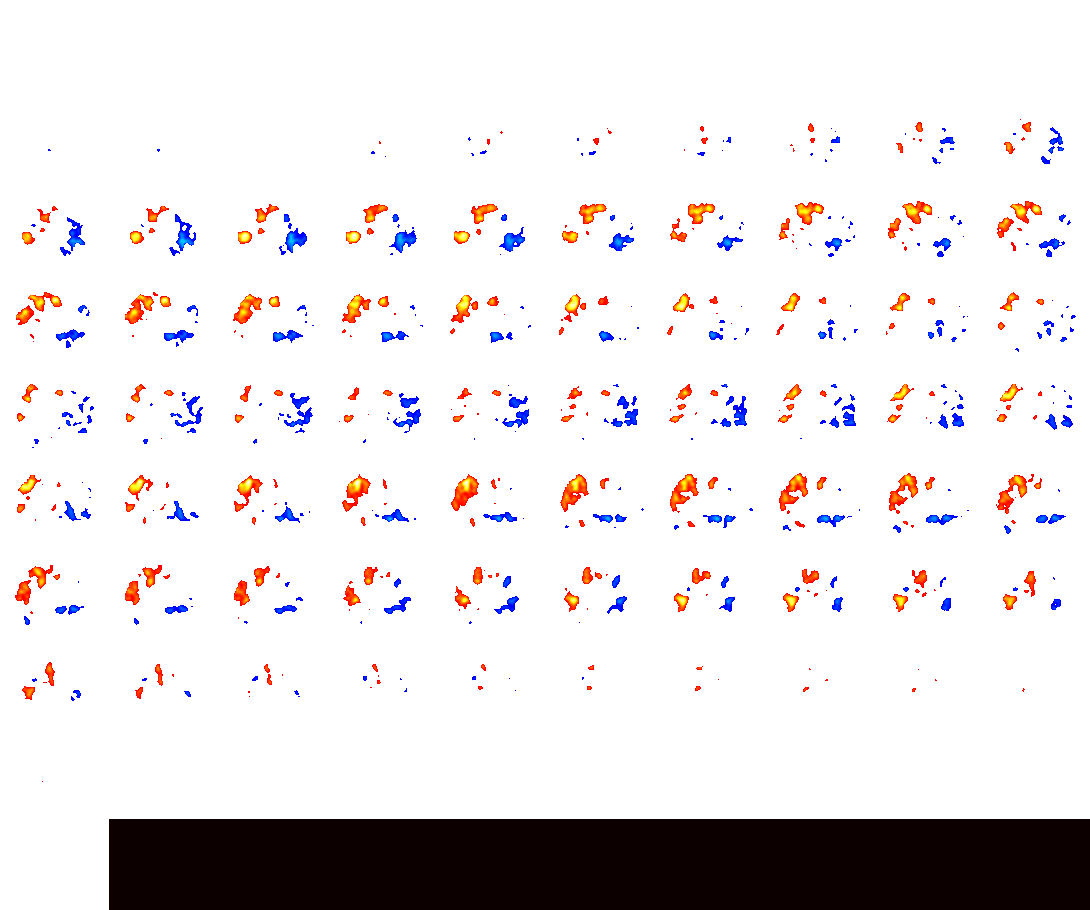

In [7]:
import scipy

def resample(nimage, scale):
  new_affine = nimage.affine.copy()
  new_affine[np.arange(3),np.arange(3)] = scale
  return nilearn.image.resample_img(nimage, new_affine)

def find_optimal_cut(image, only_consider_positive=True, z_threshold=0, use_absolute_values=True):
  data = np.array(image.get_fdata()) # Create a copy of the data

  if use_absolute_values:
    data = np.abs(data)

  data[(data < z_threshold) & (data > -z_threshold)] = 0
  if only_consider_positive:
    data[data < 0] = 0

  # Get coordinates with maximum differences
  x = np.sum(data, axis=(1,2)).argmax() + image.header.get('qoffset_x')
  y = np.sum(data, axis=(0,2)).argmax() + image.header.get('qoffset_y')
  z = np.sum(data, axis=(0,1)).argmax() + image.header.get('qoffset_z')

  return (x, y, z)

test = resample(result.get('z_map'), 1)
x, y, z = find_optimal_cut(test, only_consider_positive=True, z_threshold=4, use_absolute_values=True)

bg_img = datasets.load_mni152_template()
bg_img = "drive/MyDrive/NICER ASD/MNI152_T1_2mm.nii.gz"
view = view_img(test, threshold=3, cut_coords=(x,y,z), bg_img=bg_img)
print(x,y,z)
view


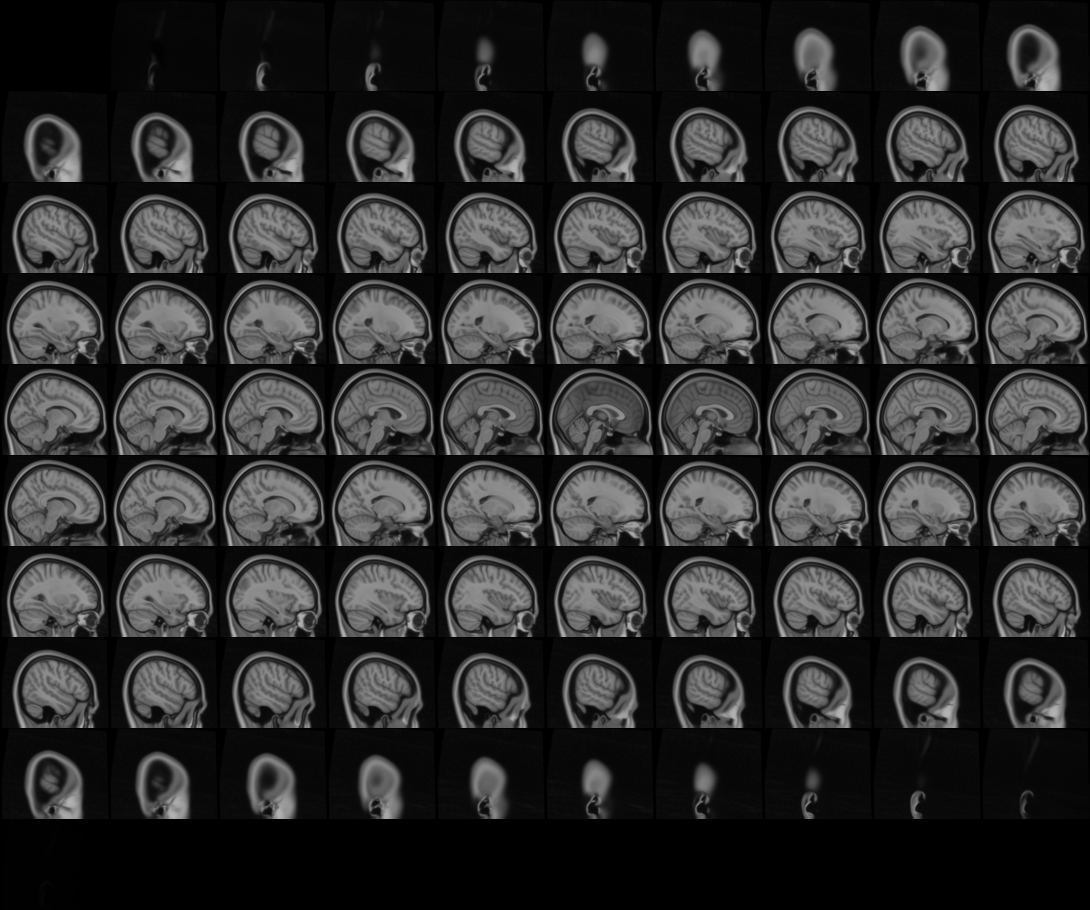
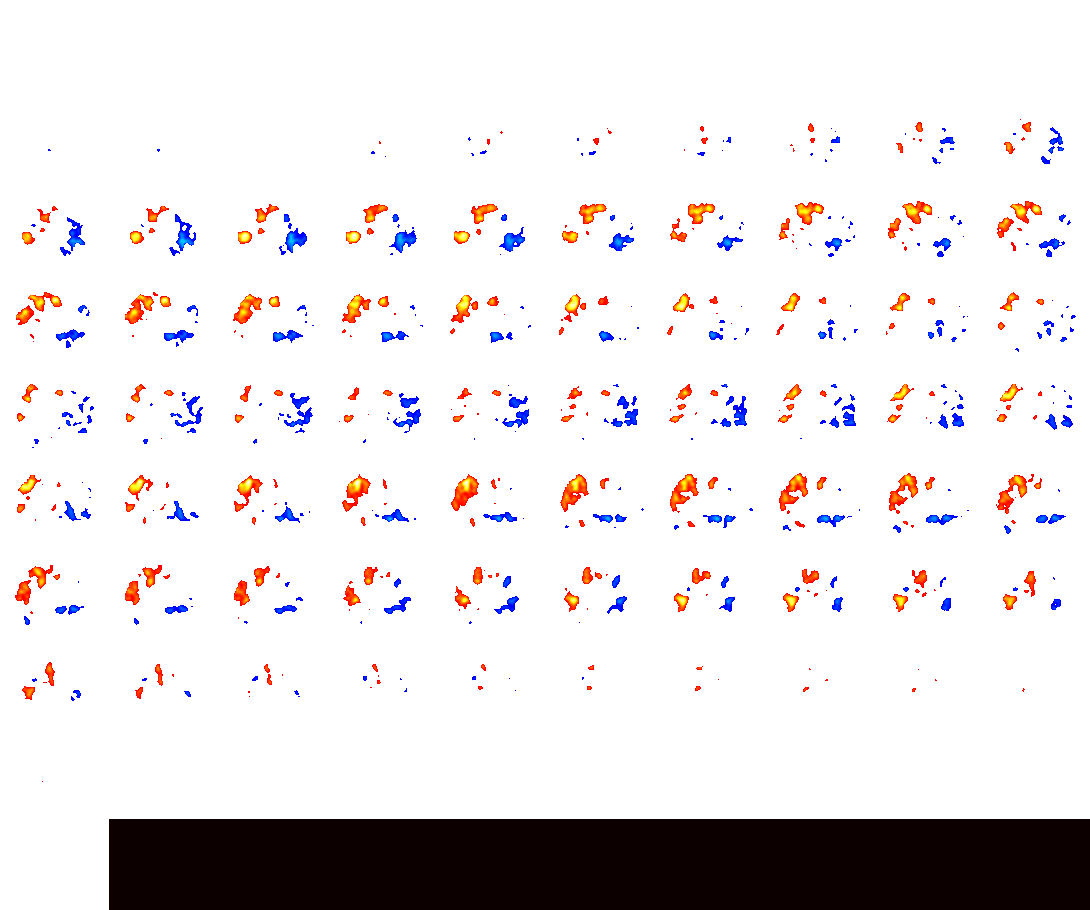

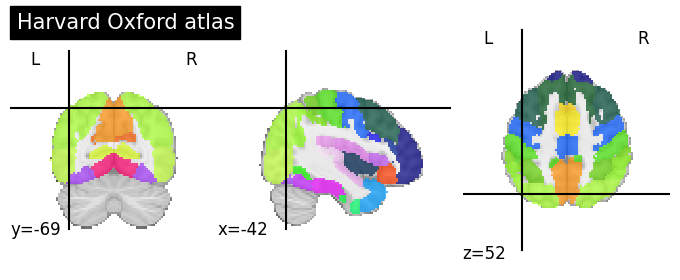

In [8]:
from nilearn import plotting

# plotting.plot_img(test, cut_coords=(x,y,z), bg_img="drive/MyDrive/NICER ASD/MNI152_T1_2mm.nii.gz", colorbar=True)
view = view_img(test, threshold=3, cut_coords=(x,y,z), bg_img=bg_img)
plotting.plot_roi(atlas_ho_filename, cut_coords=(x,y,z), title="Harvard Oxford atlas")
view


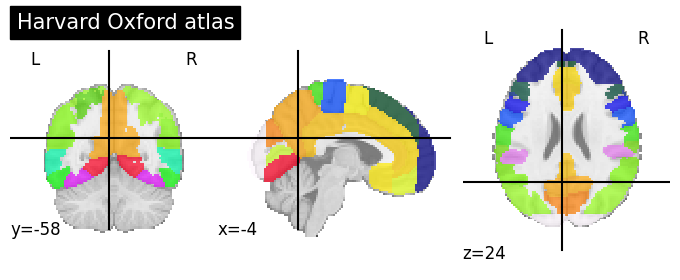

In [9]:
# for Mason

plotting.plot_roi(atlas_ho_filename, cut_coords=(-4, -58,24), title="Harvard Oxford atlas")
plt.savefig('masons_harvard_oxford_atlas.png')

In [10]:
atlas_ho_filename

'/root/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz'

In [11]:
img = nilearn.image.load_img(atlas_ho_filename)
mask = nilearn.maskers.NiftiLabelsMasker(img)
mask.labels

In [12]:
from nilearn.maskers import NiftiMasker

from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

# One subject of brain development fmri data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
fmri_filenames = data.func[0]
reduced_confounds = data.confounds[0]

Atlas ROIs are located in nifti image (4D) at: 
<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine:
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform

 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


In [14]:

from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(test)

dict(zip(labels[1:],  time_series.reshape(-1).tolist()))

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1552b1bac0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f15525f4e50>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f154d17fc40>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': False,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  

{'Frontal Pole': -1.5546633551892446,
 'Insular Cortex': -1.380315018250081,
 'Superior Frontal Gyrus': -0.9131589195057024,
 'Middle Frontal Gyrus': -1.4157236134254028,
 'Inferior Frontal Gyrus, pars triangularis': -2.7001225472191326,
 'Inferior Frontal Gyrus, pars opercularis': -2.009487062484358,
 'Precentral Gyrus': 0.9846907121332111,
 'Temporal Pole': -1.8891105575732676,
 'Superior Temporal Gyrus, anterior division': -0.22561593938185034,
 'Superior Temporal Gyrus, posterior division': 0.716752383627258,
 'Middle Temporal Gyrus, anterior division': -1.2475454783896152,
 'Middle Temporal Gyrus, posterior division': -0.8684344633437545,
 'Middle Temporal Gyrus, temporooccipital part': 0.4202429202799981,
 'Inferior Temporal Gyrus, anterior division': -0.8110395410119783,
 'Inferior Temporal Gyrus, posterior division': -0.6262249761541465,
 'Inferior Temporal Gyrus, temporooccipital part': 0.37633382524209075,
 'Postcentral Gyrus': 1.689235434011374,
 'Superior Parietal Lobule': 

In [16]:
masker

NiftiLabelsMasker(labels_img=<nibabel.nifti1.Nifti1Image object at 0x7f154d17fc40>,
                  memory=Memory(location=nilearn_cache/joblib), verbose=5)

In [17]:
m = masker.labels_img.get_fdata()
set(m.reshape(-1).tolist())


{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0}


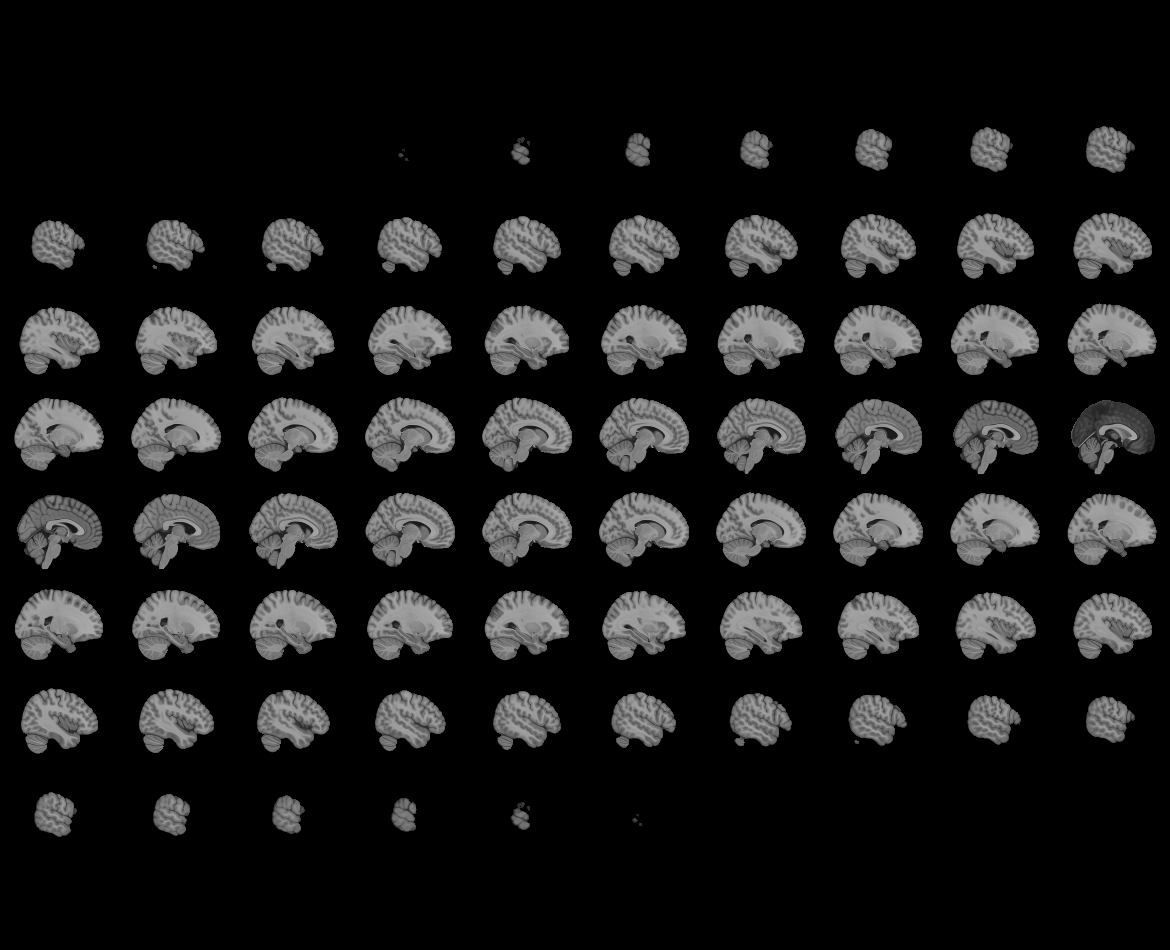
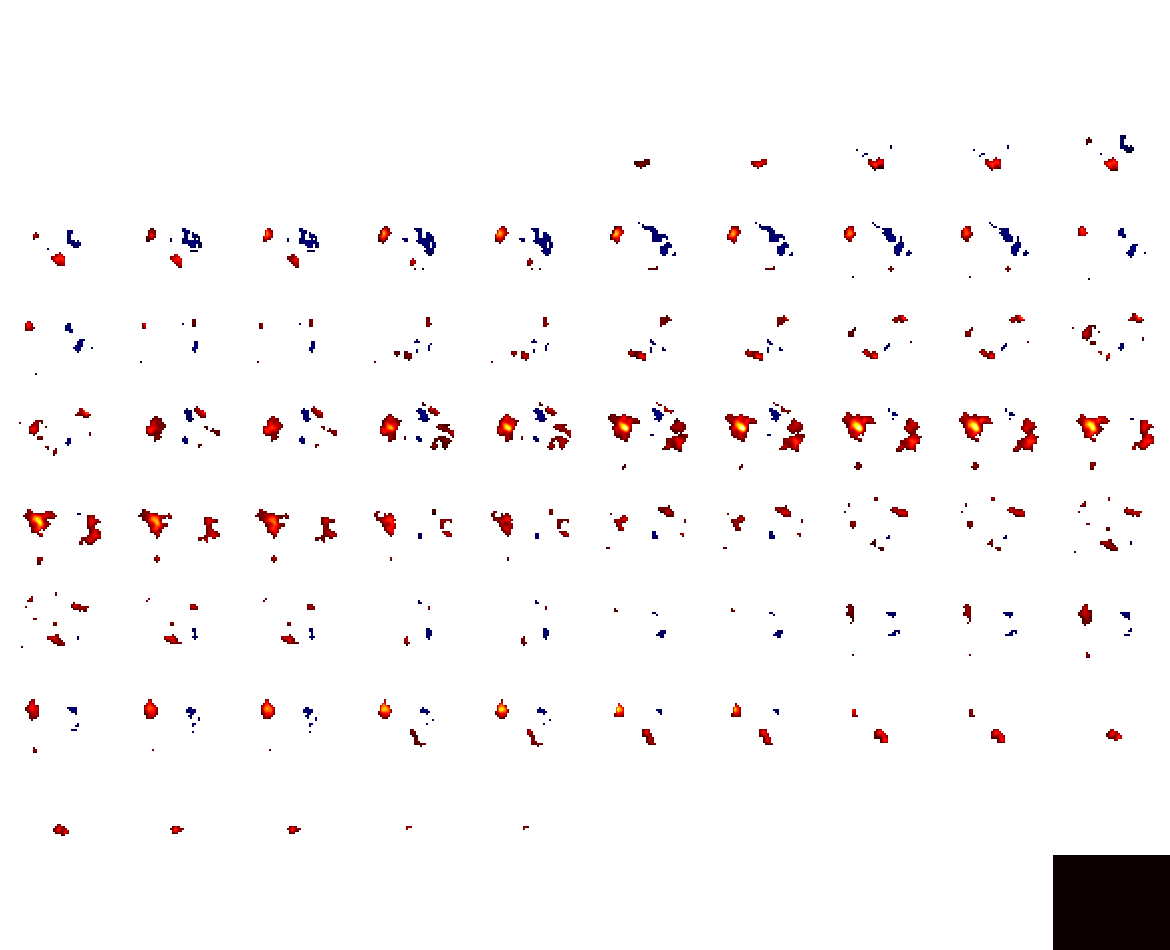


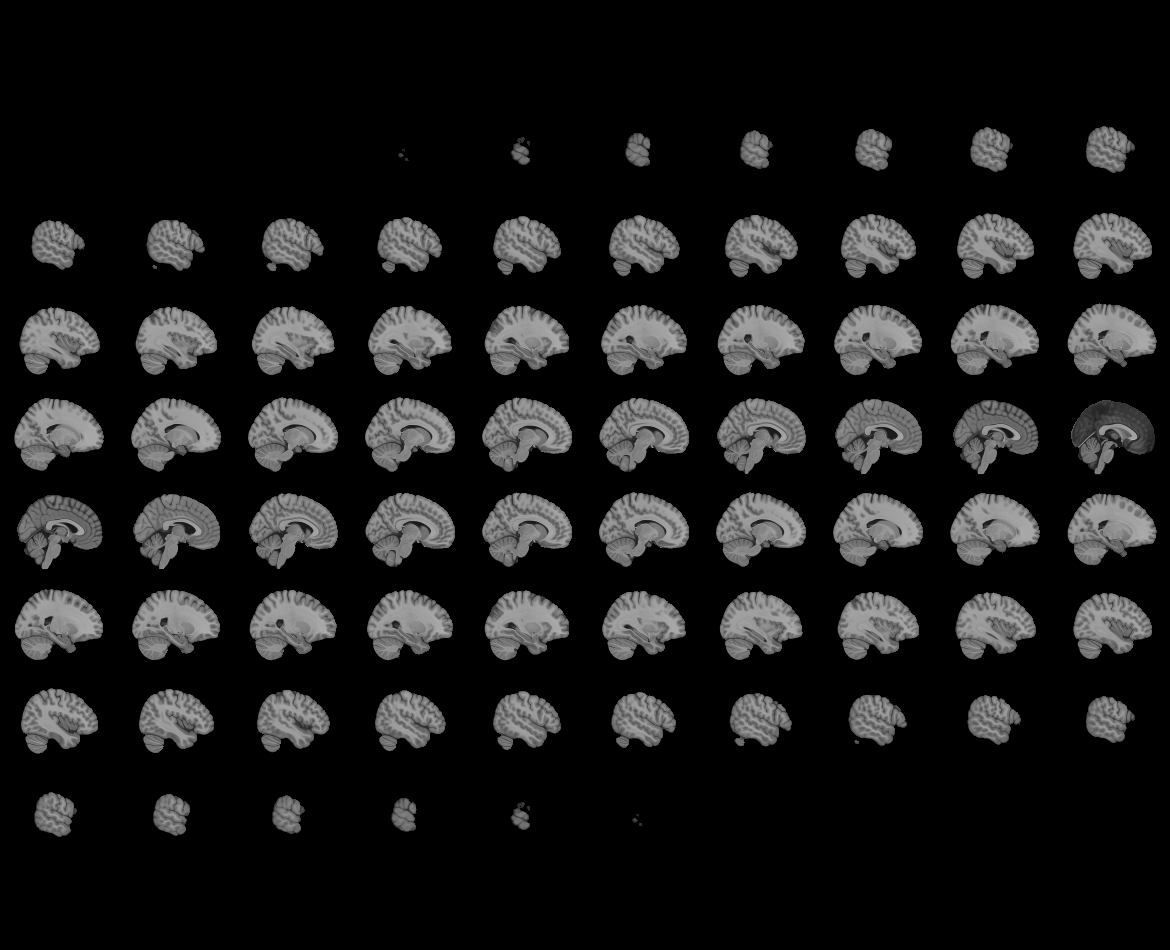
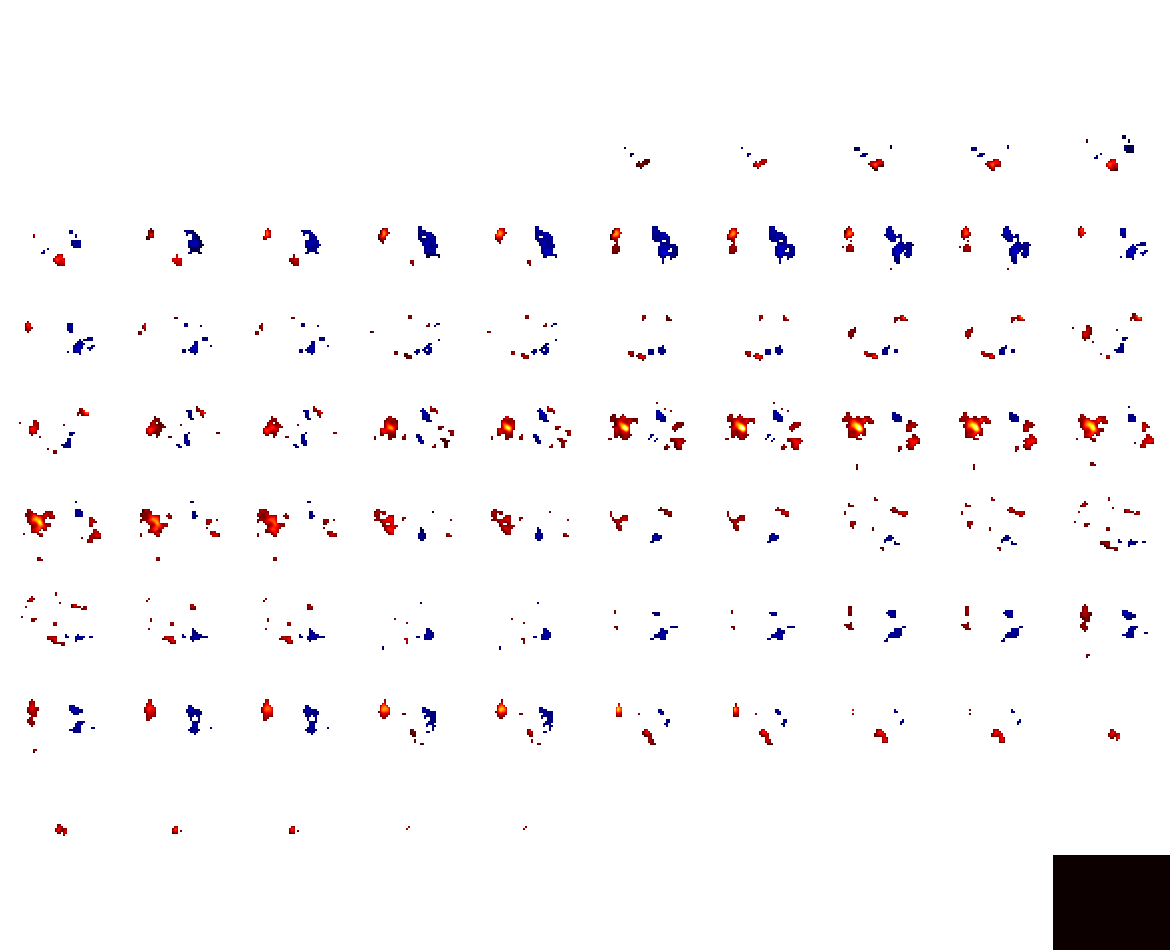

KeyboardInterrupt: ignored

In [18]:
for query in queries:
    for group in ["with", "without"]:
        full_query = f"{query.text} {group} autism spectrum disorder"
        result = encoder(full_query)
        view = view_img(result["brain_map"], threshold=3, cut_coords=query.cut)
        display(HTML(f"<h3>{full_query}</h3>"))
        display(view)

In [105]:

dataset_ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset_ho.maps

atlas_ho_filename = dataset_ho.filename

labels = dataset_ho.labels

img = nilearn.image.load_img(atlas_ho_filename)
mask = nilearn.maskers.NiftiLabelsMasker(img)

m = nilearn.masking.resampling.resample_img(img, test.affine)
assert test.get_fdata().shape == m.get_fdata().shape

arr = test.get_fdata()
marr = m.get_fdata()
values = np.unique(m.get_fdata()).astype(int)

data = []
for v in values:
  label = labels[v]
  print(label, arr[marr==v].mean())


Background -0.009938211794985106
Frontal Pole -0.9271505361766742
Insular Cortex -0.820771829723849
Superior Frontal Gyrus -0.6806080524874185
Middle Frontal Gyrus -1.0396739463794473
Inferior Frontal Gyrus, pars triangularis -0.8861842472533891
Inferior Frontal Gyrus, pars opercularis -0.6720732994069081
Precentral Gyrus 0.6744872123579366
Temporal Pole -0.9053976235097259
Superior Temporal Gyrus, anterior division -0.08178617728781587
Superior Temporal Gyrus, posterior division 0.5249010549771372
Middle Temporal Gyrus, anterior division 0.31007576143529775
Middle Temporal Gyrus, posterior division -0.17112314164414894
Middle Temporal Gyrus, temporooccipital part 0.14201341689777794
Inferior Temporal Gyrus, anterior division -0.25327617518885415
Inferior Temporal Gyrus, posterior division -0.11677023635503013
Inferior Temporal Gyrus, temporooccipital part 0.34844208317468567
Postcentral Gyrus 1.438694178164635
Superior Parietal Lobule 2.446180789838542
Supramarginal Gyrus, anterior di

In [99]:
img.header.